**Notebook 2:** LLM Architecture Intuitions

In the previous notebook, we explored the surface-level interface of HuggingFace &#x1F917; pipelines and peeked beneath the abstraction. You should now be familiar with the `preprocess -> forward -> postprocess` structure which simplifies the natural language interface for typical use.

In this notebook, we’ll dig deeper into the mechanisms behind these abstractions, focusing on how the models handle data and reason about sequences at a fundamental level.

#### **Learning Objectives:**

- Understand tokenization and embedding: how input data is represented and what properties the network leverages.
- Explore transformer encoder architectures for sequence-level reasoning in an $n$-sequence-in, $n$-sequence-out formulation.

<hr>
<br>

## **Part 2.1:** Getting The Model Inputs

We previously discussed that the pipeline converts data to and from tensor representations via the `preprocess` and `postprocess` stages. In `preprocess`, the tokenizer converts the input string into a series of ***tokens*** — symbolic representations of words, letters, or subwords — that function as basic building blocks of a sentence. This tokenization process is fundamental to all large language models since it gives us something to latch onto.

In [1]:
from transformers import pipeline

unmasker = pipeline('fill-mask', model='bert-base-uncased')

## Testing out the tokenizer
msg = "Hello world!"
print("Tokenize:", unmasker.tokenizer.tokenize(msg))      ## See token boundaries
print("Encoding:", x := unmasker.tokenizer.encode(msg))   ## See special tokens at end
print("Decoding:", x := unmasker.tokenizer.decode(x))     ## See decoding

## Specifying multiple sentences
unmasker.tokenizer("Hello world!", "Have a great day!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Tokenize: ['hello', 'world', '!']
Encoding: [101, 7592, 2088, 999, 102]
Decoding: [CLS] hello world! [SEP]


{'input_ids': [101, 7592, 2088, 999, 102, 2031, 1037, 2307, 2154, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

**When given our string, the tokenizer responds with several components:**
- `input_ids`: These are just the IDs of the tokens that make up our sentence. Said tokens can be words, punctuation, letters, whatever. Just individual entries out of a set vocabulary, exactly like classes.
- `token_type_ids`: A flag indicating whether a token is part of the first or second sentence, which is useful for BERT’s training and select tasks but will not affect us.
- `attention_mask`: Regulates which sequence entry each other sequence entry can attend to during processing. We’ll explore this later.

For our purposes, `input_ids` are the most crucial. These token ID sequences allow LLMs to reason about natural language by treating samples as an ordered sequence of tokens. This should feel somewhat familiar if you’ve worked with classification tasks in deep learning, although reasoning over sequences introduces additional complexity.

<hr>
<br>

## **Part 2.2:** Capturing Token Semantics

Now that we understand natural language reasoning as working with an ordered sequence of tokens, how do we approach this? Let’s break it down using some familiar concepts from deep learning:

- **On the output side**, we can predict a probability distribution over possible classes. For example, if we’re classifying among the tokens `cat`, `dog`, and `bird`, we output a vector like `<is_cat, is_dog, is_bird>`. The ground truth is represented as a one-hot vector, where the correct class is 1 and the rest are 0.

- **On the input side**, while one-hot encoding could work, it’s more efficient to use an **Embedding Layer**. This is essentially a matrix where the class index points to a row of semantic information. Whether we use a one-hot vector or an embedding, the model maintains a record of class semantics (either in the weights of the first layer or in a lookup matrix).

We can look over our unmasker's embedding strategy as follows:

In [7]:
model = unmasker.model
#dir(model)
#dir(model.bert)
model.bert.embeddings
# model.bert.embeddings.word_embeddings
# model.bert.embeddings.position_embeddings
# model.bert.embeddings.token_type_embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

From this, we can identify the 3 components discussed in the presentation:
- **Word Embeddings:** Semantic vectors representing the input tokens.
- **Position Embeddings**: Semantic vectors representing the position of the words.
- **Token Type Embedding**: Semantic vectors representing whether the token belongs to the first or second sentence.

Notice how the `Embedding` component is constructed with the format:

```
Embedding(in_channel, out_channel)
```

We can see from this that BERT uses 768-dimensional embeddings, and can speculate on how they are obtained. The word embeddings seem to be coming from a 30,522-dimensional vector (the number of unique tokens in the vocabulary), the positional ones from 512, and the token types from just a few. Let's explore these a bit further.

#### **Investigating the Word Embeddings**

Let’s start by examining the word embeddings of a sample sentence:

In [8]:
import torch

tokenizer = unmasker.tokenizer

string = "Hello World From Me, my cat and my dog!"
tokens = [tokenizer.convert_ids_to_tokens(x) for x in tokenizer.encode(string)]
token_ids = torch.tensor(tokenizer(string)['input_ids'])
embeddings = model.bert.embeddings.word_embeddings(token_ids)
print(embeddings.shape)
embeddings

torch.Size([13, 768])


tensor([[ 0.0136, -0.0265, -0.0235,  ...,  0.0087,  0.0071,  0.0151],
        [-0.0043, -0.0330, -0.0217,  ..., -0.0425, -0.0127, -0.0389],
        [ 0.0244,  0.0322,  0.0024,  ..., -0.0424, -0.0054, -0.0284],
        ...,
        [-0.0149,  0.0124,  0.0091,  ..., -0.0445, -0.0193,  0.0234],
        [ 0.0298, -0.0373, -0.0356,  ...,  0.0161,  0.0192,  0.0173],
        [-0.0145, -0.0100,  0.0060,  ..., -0.0250,  0.0046, -0.0015]],
       grad_fn=<EmbeddingBackward0>)

The output confirms that each token in our sentence is mapped to a 768-dimensional vector. These embeddings capture the meaning of each token. To explore this further, let’s define some helper functions to compute and visualize similarity between embeddings.

In [9]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def cosine_similarity(x1, x2):
    """Compute cosine similarity between two vectors."""
    x1_normalized = x1 / torch.norm(x1, dim=1, keepdim=True)
    x2_normalized = x2 / torch.norm(x2, dim=1, keepdim=True)
    return x1_normalized @ x2_normalized.T

def scaled_dp_similarity(x1, x2):
    """Compute dot-product similarity between two vectors."""
    dot_product = x1 @ x2.T
    d = torch.sqrt(torch.tensor(x1.shape[-1]))
    return dot_product / d

def softmax_similarity(x1, x2):
    """Compute softmaxed dp similarity between two vectors."""
    out = scaled_dp_similarity(x1, x2)
    return torch.softmax(out, dim=1)

def plot_mtx(matrix, name='', tokens=[]):
    """Compute similarity matrix for embeddings."""
    # Plot similarity matrix
    plt.figure(figsize=(10, 8))
    label_dict = {} if tokens is None else {'xticklabels' : tokens, 'yticklabels': tokens}
    sns.heatmap(
        np.round(matrix.detach().numpy(), 3),
        annot=True, cmap='coolwarm',
        # vmin=-1, vmax=1,
        **label_dict
    )
    plt.title(f"Embedding {name} Matrix")
    plt.yticks(rotation=0)
    plt.show()

With these visualization and metric functions defined, we can view the similarities of the embeddings in different measurement spaces:

#### **Basic Cosine Similarity**

The following will compute the cosine similarity:

```python
plot_mtx(cosine_similarity(embeddings, embeddings), 'Cosine Sim', tokens)
```

This produces a normalized similarity matrix that shows the cosine similarity between each pair of token embeddings. While this captures angular relationships, it discards magnitude information.

#### **Softmax Attention**

As we'll soon see this idea being incorporated into the architecture, it's worth investigating what happens when we decide to transition to softmax-based similarity:

```python
plot_mtx(softmax_similarity(embeddings, embeddings), 'Softmax(x1) Sim', tokens)
```
You'll see that the matrix is no longer symmetric since we're applying softmax on a per-row basis, but it does have a nice intuitive analog when you format it as a matrix product: **Relative to the others, how much does a token contribute to every other token?** This formulation will come up later as "attention."

You'll also notice that the magnitudes are pretty small, but we can increase the magnitude of the embeddings and observe a much more polarizing similarity matrix.

```python
plot_mtx(softmax_similarity(embeddings*10, embeddings*10), 'Softmax(x10) Sim', tokens)
```
  
Because the metric now factors magnitude into the decision process but keeps the output bounded and under control, this is a great choice when you want to inject similarity into optimization (again, foreshadowing).

Regardless, the takehome message for word embeddings is roughly **"learned vector representation for each token based on its meaning and usage in sentences."**

In [ ]:
plot_mtx(cosine_similarity(embeddings, embeddings), 'Cosine Sim', tokens)

# plot_mtx(scaled_dp_similarity(embeddings, embeddings), 'Scaled DP Sim', tokens)
# plot_mtx(scaled_dp_similarity(embeddings*10, embeddings), 'Scaled DP (x10, x1) Sim', tokens)
# plot_mtx(scaled_dp_similarity(embeddings*10, embeddings*10), 'Scaled DP (x10, x10) Sim', tokens)

# plot_mtx(softmax_similarity(embeddings, embeddings), 'Softmax(x1) Sim', tokens)
# plot_mtx(softmax_similarity(embeddings*10, embeddings*10), 'Softmax(x10) Sim', tokens)

#### **Investigating the Positional Embeddings**

Now that we've seen the word embeddings, we can take a look at the positional embeddings:

```python
model.bert.embeddings.position_embeddings ## -> Embedding(512, 768)
```

In contrast to the word embeddings, these are 512-dimensional and capture the semantics of the different positions in the input sequence. That way, our aggregate embedding can reason about both the words themselves and where they are in the sentence.

You'll notice that the positional embedding has a more predictable and uniform cosine similarity plots compared to the word embeddings, which are all actually pretty consistent with a few key exceptions.

**You're free to visualize a subset of the positional embeddings matrix below.**

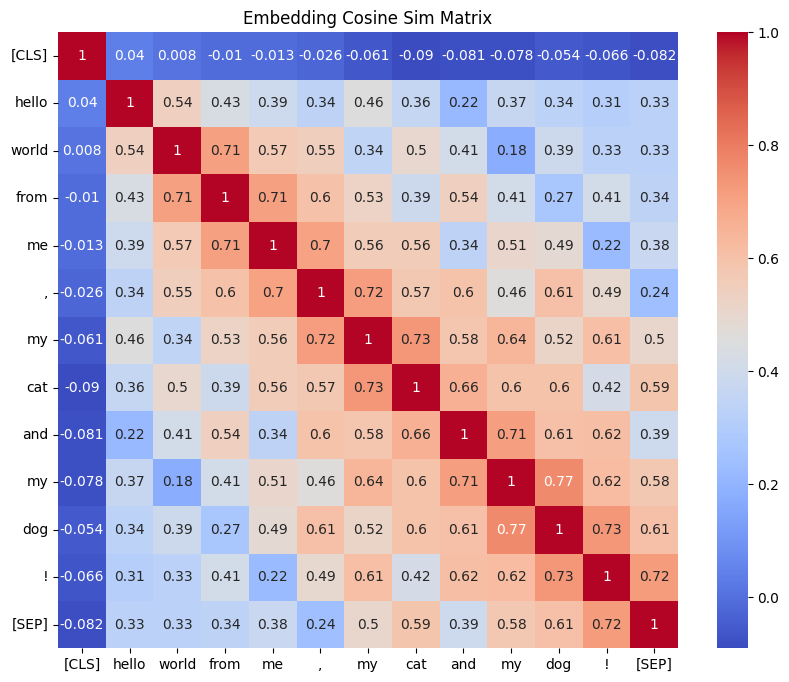

In [10]:
pos_options = torch.arange(len(tokens)) ## 0, 1, ..., n
pos_embeddings = model.bert.embeddings.position_embeddings(pos_options)
plot_mtx(cosine_similarity(pos_embeddings, pos_embeddings), 'Cosine Sim', tokens)

#### **Wrapping Up The Embeddings**

To wrap up our embedding discussions, we do still have our **token_type_embedding** embeddings, but they follow roughly the same logic; take in some extra semantic information about the sentence structure, encode it to some compatable representation, and incorporate it into the input. The authors saw this extra information as useful for supervising the model's training routine, so the overall embedding definition for BERT is:

`embed = WordEmbed[token] + PosEmbed[pos] + TypeEmbed[pos]`

In [ ]:
model.bert.embeddings

Then at the end, the LayerNorm section and Dropout section are also included, and these will permeate your architectures going forward. A light discussion is sufficient to motivate them:

- The [**LayerNorm layer**](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html) normalizes the data flowing through it so that each minibatch subscribes to a similar distribution. You've probably seen [**BatchNorm**](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) from computer vision; this has a similar logic, but now the normalization covers the layer outputs instead of the batch. For some more discussion, we found the [**PowerNorm paper**](https://arxiv.org/abs/2003.07845) helpful.
- The [**Dropout layer**](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) just masks out some of the values during training. You've probably seen this before, and the logic is the same as usual; prevent over-reliance on a selection of features and distribute the logic throughout the network.

HuggingFace, being open-source, provides insight into these components. You can find the BERT implementation in [`transformers/models/bert/modeling_bert.py`](https://github.com/huggingface/transformers/blob/0a365c3e6a0e174302debff4023182838607acf1/src/transformers/models/bert/modeling_bert.py#L180C11-L180C11), which may shed light on some lingering questions like "is this addition or concatenation" (it's addition) or "do we need more considerations to make this scheme work in practice" (yes).

<hr>
<br>

## **Part 2.3:** From Token-Level to Sequence-Level Reasoning

**To summarize the key points of the LLM intake strategy:**

- A passage is **tokenized** into an ordered sequence of tokens (unique class instances).
- The tokens are **embedded** into a vector that captures useful semantic features (meaning, position, etc).


**With this, we have some obvious options for how to reason about our data:**

1. **Token-by-token reasoning**: Treat each token in isolation (like classification tasks).
    - **Problem**: Tokens need to understand the context of other tokens in the sequence.
2. **Dense layer approach**: Reason about the sequence as a whole by combining all tokens at once.
    - **Problem**: Creates an intractable neural network.

The LLM solution is to do something between those two options:
> Allow reasoning to be done **on each token *(Token-Level Reasoning)***, but also allow for small opportunities in which the network can **consider the sequence as a whole *(Sequence-Level Reasoning)***!

That's where the **transformer** components come in!

#### **Transformer Attention**

Transformers, introduced in the 2017 paper [*Attention Is All You Need*](https://arxiv.org/abs/1706.03762), have become central to state-of-the-art language models. This architecture uses an ***attention mechanism*** to create an interface where the other entries of the sequence can communicate semantic information to other tokens in the series.

The formulation goes as follows: If we have semantic and positional information present in our embeddings, we can train a mapping from our embeddings into three semantic spaces $K$, $Q$, and $V$:

- **$K$ (Key)** and **$Q$ (Query)** are arguments to a similarity function (recall scaled softmax attention) to guage how much weight should be given between any pair of sequence entries in the input.

- **$V$ (Value)** is the information that should pass through to the next component, and is weighted by `SoftmaxAttention(Key, Query)` to produce an output that is positionally and semantically motivated.


**In other words:** Given a semantic/position-rich sequence of $d_k$-element embeddings ($S$) and three dense layers ($K$, $Q$, and $V$) that operate per-sequence-entry, we can train a neural network to make semantic/position-driven predictions via the forward pass equation:

$$\text{Self-Attention} = \text{SoftmaxAttention}(K_s, Q_s) \cdot V_s$$$$= \frac{K_s Q_s ^T}{\sqrt{d_k}}V_s$$

**This effectively lets us produce:**
- **$K(E),V(E),Q(E)$:** Three different embeddings derived from $E$.
- **$\sigma(A)$:** Gives intuition of how each embedding relates to all the other embeddings.
- **$\sigma(A)V$:** Embedding which considers both (pre-interface) $V$ and (post-interface) attention.

<div><img src="imgs/attention-logic.png" width="1000"/></div>

This mechanism is known as **self-attention** because the `Key`, `Query`, and `Value` vectors are derived from the same sequence. Other types of attention will be introduced later.

#### **Seeing Attention in the BERT Encoder**

Now that we understand self-attention, let's look at how BERT’s encoder handles our embeddings:

In [ ]:
unmasker.model.bert.encoder

Those interested can dig much deeper into the implementation details, a high-level overview should be sufficient to see the big picture:
- `BertSdpa(ScaledDotProductAttention)SelfAttention`: This component takes a sequence of vectors (let's call it `x`) as input and gets the `Q`, `K`, and `V` components via `query(x)`, `key(x)`, and `value(x)`, respectively. As these are all $768$-dimensional vectors - and are thereby multiplicatively compatible under transpose - the layer performs the attention computation with a few key modifications:
    - **Multi-Headed Attention:** $K$, $Q$, and $V$ are all slices up along the embedding dimension such that we get 12 trios with dimension $768/12 = 64$. This will give us 12 different attention results, allowing the network to distribute attention in a variety of ways. After all 12 results are obtained, just concatenate embedding-wise and you'll be back up to 768-feature vectors.
    - **Masked Attention:** This is less useful for BERT but explains what the `attention_mask` input is doing. Essentially, it's a true-or-false "should-I-add-negative-infinity-to-the-attention" mask to keep the model from attending to things it shouldn't. This will be more useful in later architectures.
    - **Residual Connections:** To help the network keep the token-level information propagating through the network and improve the overall gradient flow, most architectures add residual connections around the transformer components.

- `BertSelfOutput -> BertIntermediate -> BertOutput`: These are all just token-level dense layers with non-linear activations and some `LayerNorm`/`Dropout` layers mixed in for regularization. Each element in the sequence is thereby fed through an MLP *(multi-later perceptron, or multi-layer dense network)* with dimensions progressing through $768 \to 768 \to 3072 \to 768$ to create a new data representation.

BERT stacks 12 such layers in sequence. Each layer performs attention, followed by token-wise transformations, resulting in deep reasoning about the input tokens. Not too bad, right?

<div><img src="imgs/bert-construction.png" width="800"/></div>

#### **Visualizing The Attention Mechanism In Action**

We can request the realized attention values computed at each `SelfAttention` layer by specifying `output_attentions=True`:

In [ ]:
import torch

## Tokenization Efforts
string = "Hello Mr. Bert! How is it [MASK]?"
input_tensors = unmasker.preprocess(string)
input_ids = unmasker.tokenizer.encode(string)
input_tokens = unmasker.tokenizer.convert_ids_to_tokens(input_ids)

## Encoding Efforts
embeddings = unmasker.model.bert.embeddings(input_tensors['input_ids'])
x = unmasker.model.bert.encoder(embeddings, input_tensors['attention_mask'], output_attentions=True)

print("From encoder.forward():")
for k,v in x.items():
    v = v if hasattr(v, "shape") else torch.stack(v)
    print(f" > '{k}' : {v.shape}")

To visualize this, we can use the [**`BertViz` package**](https://github.com/jessevig/bertviz) to display the attention associations from our last forward pass in an interactive grid! Please feel free to test this out with other input strings to see what changes.
- See what happens to the dimensionality when you increase the number of tokens.
- See what happens to the connections, and see if you see any patterns worth noting.
- Why do you think the CLS and SEP tokens get so much attention in many of the attention heads?

In [ ]:
from bertviz import model_view

model_view(x['attentions'], input_tokens)  # Display model view